# 2D Nuclear Segmentation with Mask-RCNN

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# create folder for this set of experiments
experiment_folder = "retina_mask"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/20201018_freeze/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [18]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20201018_multiplex_seed_3_"

train_dict = np.load(NPZ_DIR + npz_name + "train_512x512.npz")

In [19]:
X_train, y_train = train_dict['X'], train_dict['y']

In [21]:
X_train = X_train[:, 100:356, 100:356, :]
y_train = y_train[:, 100:356, 100:356, :]

In [22]:
from deepcell_toolbox.multiplex_utils import multiplex_preprocess
X_train = multiplex_preprocess(X_train)

In [23]:
np.savez_compressed(NPZ_DIR + npz_name + 'train_256x256.npz', 
                    X=X_train, y=y_train)

In [25]:
npz_name = "20201018_multiplex_seed_2_train_256x256.npz"
train_dict = np.load(NPZ_DIR + npz_name)
y_train = train_dict['y']
X_train = train_dict['X']
print(y_train.shape, X_train.shape)

(2668, 256, 256, 1) (2668, 256, 256, 2)


In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters
from deepcell.training import train_model_retinanet
from deepcell import model_zoo

model_splits = ['1', '2', '3']
for model in model_splits:
    print('loading data')
    npz_name = "20201018_multiplex_seed_{}_train_256x256.npz".format(model)
    train_dict = np.load(NPZ_DIR + npz_name)
    y_train = train_dict['y']
    
    model_name = 'retina_mask_split_{}'.format(model)
    backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

    n_epoch = 100  # Number of training epochs
    lr = 1e-4

    optimizer = Adam(lr=lr, clipnorm=0.001)

    lr_sched = rate_scheduler(lr=lr, decay=0.99)

    batch_size = 8

    num_classes = 1  # "object" is the only class
    test_size = 0.1
    seed=0
    
    print('creating backbone levels')
    # Generate backbone information from the data
    backbone_levels, pyramid_levels, anchor_params = get_anchor_parameters(y_train.astype('int'))
    
    print('creating model')

    model = model_zoo.RetinaMask(
        backbone=backbone,
        input_shape=[256, 256, 2],
        class_specific_filter=False,
        num_classes=num_classes,
        backbone_levels=backbone_levels,
        pyramid_levels=pyramid_levels,
        anchor_params=anchor_params
    )

    prediction_model = model
    
    print('training')

    model = train_model_retinanet(
        model=model,
        backbone=backbone,
        dataset=NPZ_DIR + npz_name,  # full path to npz file
        model_name=model_name,
        sigma=3.0,
        alpha=0.25,
        gamma=2.0,
        include_masks=True,  # include mask generation
        weighted_average=True,
        score_threshold=0.01,
        iou_threshold=0.5,
        max_detections=100,
        backbone_levels=backbone_levels,
        pyramid_levels=pyramid_levels,
        anchor_params=anchor_params,
        test_size=test_size,
        seed=seed,
        optimizer=optimizer,
        batch_size=batch_size,
        n_epoch=n_epoch,
        log_dir=LOG_DIR,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.7, 1/0.7))

loading data
creating backbone levels


W1108 23:25:23.981778 139694831544128 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


creating model


W1108 23:25:29.783479 139694831544128 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1108 23:25:37.622708 139694831544128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:255: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1108 23:25:38.856585 139694831544128 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:255: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_i

training


W1108 23:25:51.090556 139694831544128 training_utils.py:1101] Output filtered_detections missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections.
W1108 23:25:51.091537 139694831544128 training_utils.py:1101] Output filtered_detections_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_1.
W1108 23:25:51.092263 139694831544128 training_utils.py:1101] Output filtered_detections_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_2.
W1108 23:25:51.092930 139694831544128 training_utils.py:1101] Output mask_submodel missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to mask_submodel.


X_train shape: (2397, 256, 256, 2)
y_train shape: (2397, 256, 256, 1)
X_test shape: (267, 256, 256, 2)
y_test shape: (267, 256, 256, 1)
Output Shape: (None, 100, None)
Number of Classes: None
Training on 1 GPUs


W1108 23:25:54.659479 139694831544128 retinanet.py:357] Removing 22 of 2397 images with fewer than 3 objects.
W1108 23:25:56.221000 139694831544128 retinanet.py:357] Removing 3 of 267 images with fewer than 3 objects.


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


295/296 [============================>.] - ETA: 4s - loss: 3.1666 - regression_loss: 2.3078 - classification_loss: 0.3941 - masks_loss: 0.4647
Epoch 00001: val_loss improved from inf to 2.62996, saving model to /data/analyses/retina_mask/retina_mask_split_1.h5


W1108 23:50:44.589156 139694831544128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/deepcell/callbacks.py:158: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



30784 instances of class 0 with average precision: 0.4800
mAP: 0.4800
296/296 [==============================] - 1480s 5s/step - loss: 3.1649 - regression_loss: 2.3065 - classification_loss: 0.3938 - masks_loss: 0.4646 - val_loss: 2.6300 - val_regression_loss: 1.8414 - val_classification_loss: 0.3989 - val_masks_loss: 0.3897
Epoch 2/100
295/296 [============================>.] - ETA: 4s - loss: 2.3352 - regression_loss: 1.7107 - classification_loss: 0.2436 - masks_loss: 0.3808
Epoch 00002: val_loss improved from 2.62996 to 2.03577, saving model to /data/analyses/retina_mask/retina_mask_split_1.h5
30784 instances of class 0 with average precision: 0.5500
mAP: 0.5500
296/296 [==============================] - 1444s 5s/step - loss: 2.3349 - regression_loss: 1.7106 - classification_loss: 0.2435 - masks_loss: 0.3808 - val_loss: 2.0358 - val_regression_loss: 1.4819 - val_classification_loss: 0.2187 - val_masks_loss: 0.3351
Epoch 3/100
295/296 [============================>.] - ETA: 4s - loss

In [10]:
prediction_model.load_weights(MODEL_DIR + '/mrcnn_model.h5')

In [11]:
test_dict = np.load(NPZ_DIR + '20201018_multiplex_seed_2_test_256x256.npz')

In [13]:
from deepcell_toolbox.multiplex_utils import multiplex_preprocess
X_test, y_test = test_dict['X'], test_dict['y']
X_test = multiplex_preprocess(X_test)

Image Number: 774


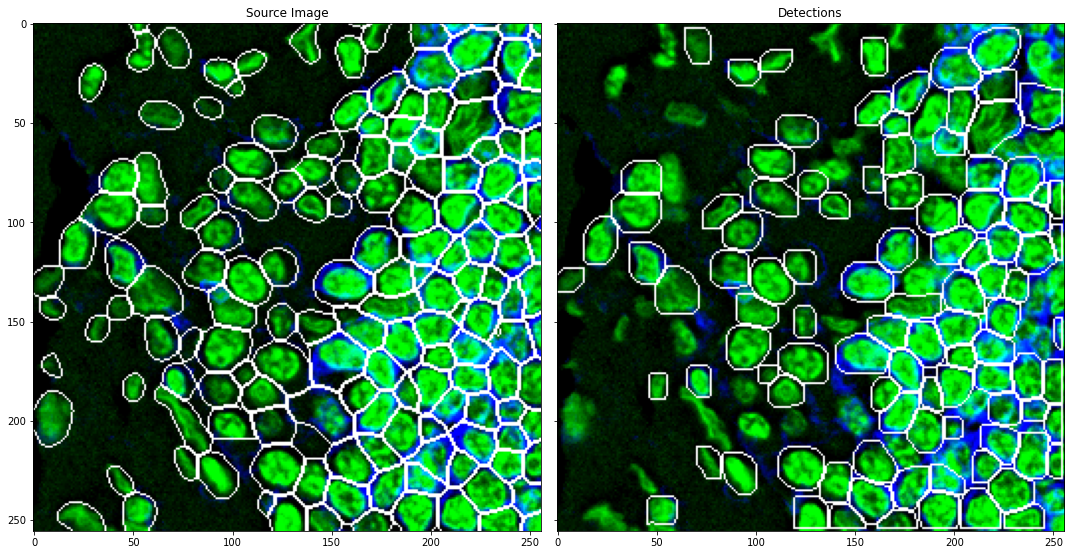

In [49]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from deepcell.utils.plot_utils import draw_detections, draw_masks, create_rgb_image, make_outline_overlay
from deepcell_toolbox.retinanet import retinamask_postprocess


index = np.random.randint(low=0, high=X_test.shape[0])
index = 774
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

boxes, scores, labels, masks = prediction_model.predict(image)[-4:]

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))

rgb_image = create_rgb_image(X_test[index:index + 1], ['green', 'blue'])
true_overlay = make_outline_overlay(rgb_image, mask)
predicted_mask =  retinamask_postprocess((boxes, scores, labels, masks), score_threshold=0.1)
predicted_overlay = make_outline_overlay(rgb_image, np.expand_dims(predicted_mask, -1))

mask = np.squeeze(mask)

# copies to draw on
draw = image.copy()

# draw the masks
draw_masks(draw, boxes[0], scores[0], masks[0],
           score_threshold=0.5)

# draw the detections
draw_detections(draw, boxes[0], scores[0], labels[0],
                label_to_name=lambda x: 'cell',
                score_threshold=0.5,)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(true_overlay[0], cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(predicted_overlay[0], cmap='jet')
ax[1].set_title('Detections')

fig.tight_layout()
plt.show()

In [30]:
masks.shape

(1, 100, 28, 28, 1)

In [22]:
masks.shape

(1, 100, 28, 28, 1)